# Grid search for Delay Embedding & Ridge Regression for NVAR

It performs a grid search over delay taps k and ridge regularization values $\alpha$, then visualizes prediction accuracy via RMSE heatmaps.

Azimov Sherkhon \\
Pusan National University \\
sherxonazimov94@pusan.ac.kr \\
May 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from scipy.integrate import solve_ivp

In [2]:
# Time settings
s = 4
dt = 0.025*s
warmup = 5.0
traintime = 38.0
testtime = 2.0
maxtime = warmup + traintime + testtime
plottime = 2.0

# Convert to discrete steps
warmup_pts = round(warmup / dt)
traintime_pts = round(traintime / dt)
warmtrain_pts = warmup_pts + traintime_pts
testtime_pts = round(testtime / dt)
maxtime_pts = round(maxtime / dt)
plottime_pts = round(plottime / dt)

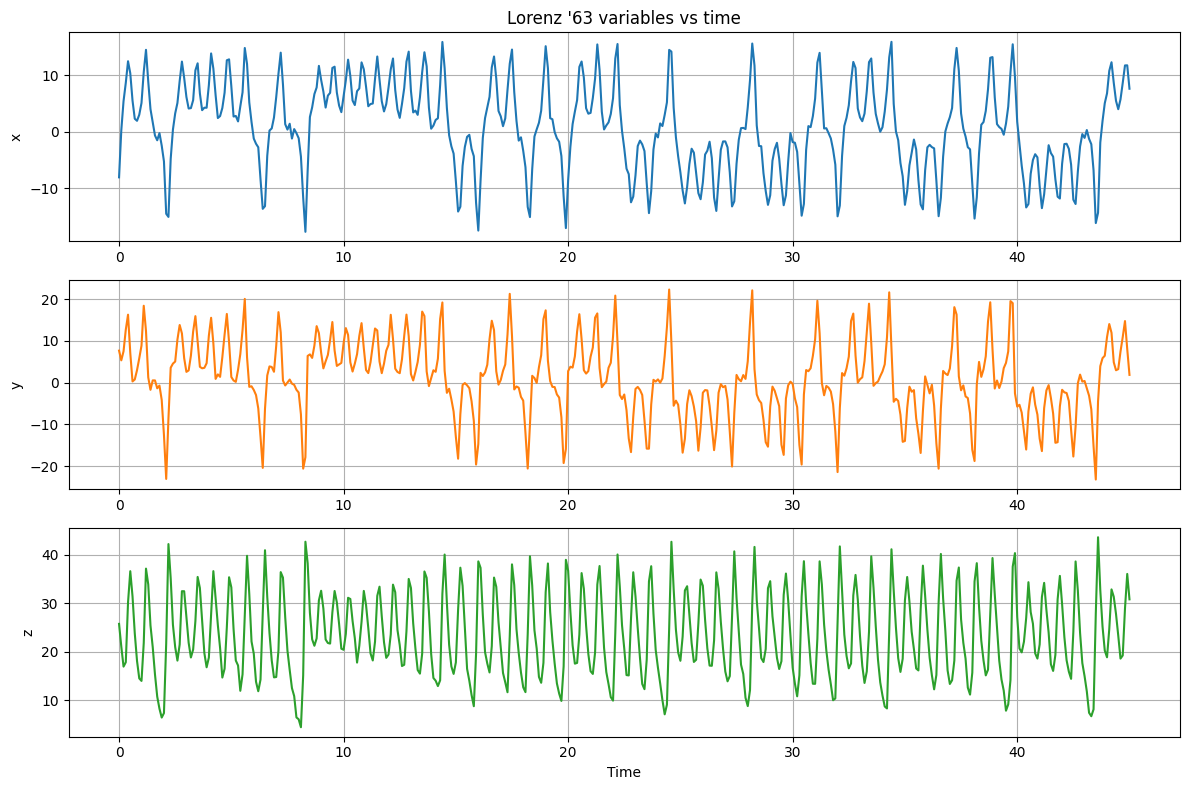

In [3]:
# ---------------------- Load Data ----------------------
t_eval = np.linspace(0, maxtime, maxtime_pts + 1)

# Lorenz system definition
sigma, beta, rho = 10, 8/3, 28

def lorenz(t, y):
    return [
        sigma * (y[1] - y[0]),
        y[0] * (rho - y[2]) - y[1],
        y[0] * y[1] - beta * y[2]
    ]
# Seed setup
seed = 2025
np.random.seed(seed)
# Integrate Lorenz system
t_eval = np.linspace(0, maxtime, maxtime_pts*s + 1)
sol = solve_ivp(lorenz, (0, maxtime), [-8.0, 7.0, 27.0], t_eval=t_eval, method="RK23")
lorenz_data = sol.y.T
t_eval = t_eval[::s]
lorenz_data = lorenz_data[::s,:]
X_clean = lorenz_data.T
# Add Gaussian noise
def add_noise(data, scale):
    std = np.std(data, axis=0)
    noise = np.random.normal(0.0, scale * std, data.shape)
    return data + noise

X_noisy = add_noise(lorenz_data, 0.10)
np.save("10percent_obs_4", X_noisy)
lorenz_soln = X_noisy.T


# Plot Lorenz variables
variables = ['x', 'y', 'z']
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_eval, lorenz_soln[i], label=variables[i], color=f'C{i}')
    plt.ylabel(variables[i])
    plt.grid(True)
    if i == 0:
        plt.title("Lorenz '63 variables vs time")
plt.xlabel('Time')
plt.tight_layout()
plt.show()

In [4]:
# ---------------------- Grid Search Parameters Phase 1 ----------------------
d = 3  # Dimension of the system
k_values = range(1, 16)  # Delay taps
ridge_values = np.linspace(1, 1000, 101)  # Ridge parameters
results = []

# ---------------------- Grid Search ----------------------
for k, ridge_param in itertools.product(k_values, ridge_values):
    dlin = k * d
    dnonlin = int(dlin * (dlin + 1) / 2)
    dtot = 1 + dlin + dnonlin

    x = np.zeros((dlin, maxtime_pts))
    for delay in range(k):
        for j in range(delay, maxtime_pts):
            x[d * delay:d * (delay + 1), j] = lorenz_soln[:, j - delay]

    # Training features
    out_train = np.ones((dtot, traintime_pts))
    out_train[1:dlin + 1, :] = x[:, warmup_pts - 1:warmtrain_pts - 1]

    cnt = 0
    for row in range(dlin):
        for col in range(row, dlin):
            out_train[dlin + 1 + cnt] = (
                x[row, warmup_pts - 1:warmtrain_pts - 1] *
                x[col, warmup_pts - 1:warmtrain_pts - 1]
            )
            cnt += 1

    # Ridge regression
    delta_x = x[0:d, warmup_pts:warmtrain_pts] - x[0:d, warmup_pts - 1:warmtrain_pts - 1]
    W_out = delta_x @ out_train.T @ np.linalg.pinv(out_train @ out_train.T + ridge_param * np.identity(dtot))

    # Prediction
    out_test = np.zeros(dtot)
    x_test = np.zeros((dlin, testtime_pts))
    x_test[:, 0] = x[:, warmtrain_pts - 1]

    for j in range(testtime_pts - 1):
        out_test[1:dlin + 1] = x_test[:, j]
        cnt = 0
        for row in range(dlin):
            for col in range(row, dlin):
                out_test[dlin + 1 + cnt] = x_test[row, j] * x_test[col, j]
                cnt += 1
        x_test[d:dlin, j + 1] = x_test[0:(dlin - d), j]
        x_test[0:d, j + 1] = x_test[0:d, j] + W_out @ out_test

    # RMSE evaluation
    X_true = x[0:3, warmtrain_pts - 1:warmtrain_pts + plottime_pts - 1]
    X_pred = x_test[0:3, 0:plottime_pts]
    rmse = np.sqrt(np.mean((X_true - X_pred) ** 2))

    results.append((k, ridge_param, rmse))

  
    print(f"k = {k:2d} | ridge = {ridge_param:.3f} | Test RMSE = {rmse:.6f}")

# ---------------------- Best Result ----------------------
valid_results = [r for r in results if not np.isnan(r[2])]
best_k, best_ridge, best_rmse = min(valid_results, key=lambda x: x[2])
print(f"Best k = {best_k}, ridge = {best_ridge:.3f} → Validation RMSE = {best_rmse:.6f}")

C:\Users\sherx\AppData\Local\Temp\ipykernel_16032\235292237.py:45: RuntimeWarning: overflow encountered in scalar multiply
  out_test[dlin + 1 + cnt] = x_test[row, j] * x_test[col, j]
C:\Users\sherx\AppData\Local\Temp\ipykernel_16032\235292237.py:48: RuntimeWarning: invalid value encountered in matmul
  x_test[0:d, j + 1] = x_test[0:d, j] + W_out @ out_test
C:\Users\sherx\AppData\Local\Temp\ipykernel_16032\235292237.py:53: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((X_true - X_pred) ** 2))


k =  1 | ridge = 1.000 | Test RMSE = nan
k =  1 | ridge = 10.990 | Test RMSE = 14.992203
k =  1 | ridge = 20.980 | Test RMSE = 11.669277
k =  1 | ridge = 30.970 | Test RMSE = 12.844622
k =  1 | ridge = 40.960 | Test RMSE = 11.702795
k =  1 | ridge = 50.950 | Test RMSE = 11.101181
k =  1 | ridge = 60.940 | Test RMSE = 10.924377
k =  1 | ridge = 70.930 | Test RMSE = 10.961887
k =  1 | ridge = 80.920 | Test RMSE = 11.013005
k =  1 | ridge = 90.910 | Test RMSE = 10.983256
k =  1 | ridge = 100.900 | Test RMSE = 10.888928
k =  1 | ridge = 110.890 | Test RMSE = 10.768046
k =  1 | ridge = 120.880 | Test RMSE = 10.645058
k =  1 | ridge = 130.870 | Test RMSE = 10.531122
k =  1 | ridge = 140.860 | Test RMSE = 10.429944
k =  1 | ridge = 150.850 | Test RMSE = 10.341799
k =  1 | ridge = 160.840 | Test RMSE = 10.265594
k =  1 | ridge = 170.830 | Test RMSE = 10.199814
k =  1 | ridge = 180.820 | Test RMSE = 10.142910
k =  1 | ridge = 190.810 | Test RMSE = 10.093456
k =  1 | ridge = 200.800 | Test RMSE 

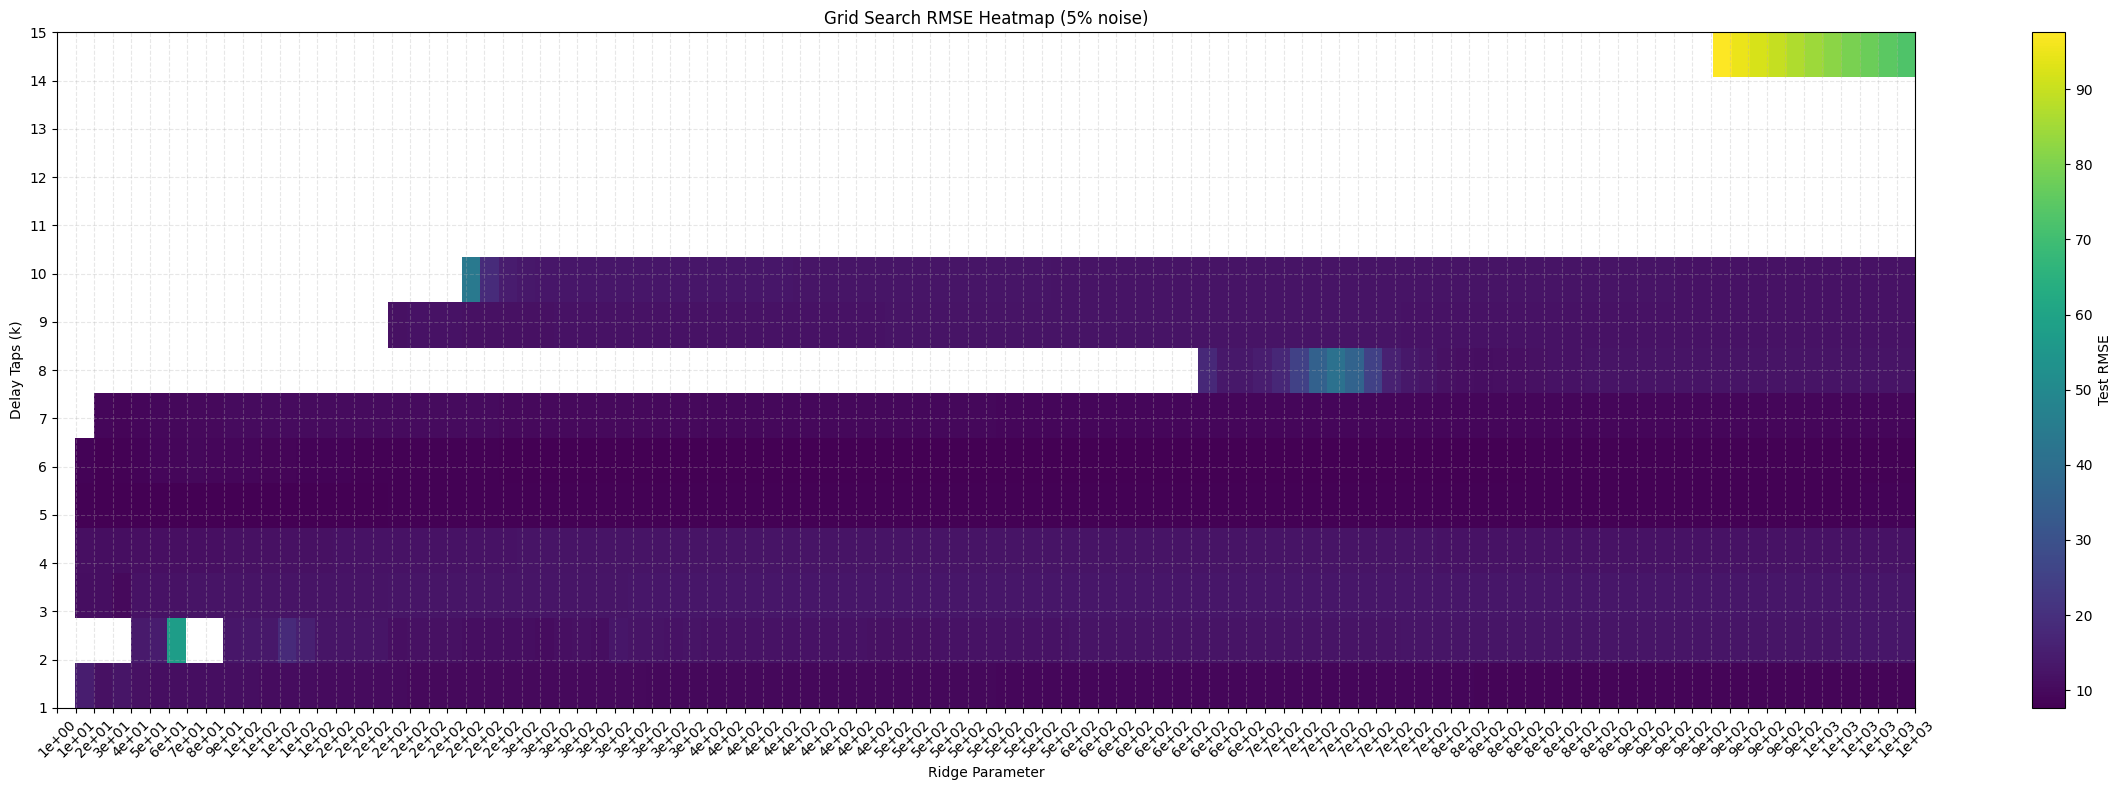

In [5]:
# ---------------------- Heatmap Phase 1 ----------------------
k_list = sorted(set(k for k, _, _ in results))
ridge_list = sorted(set(r for _, r, _ in results))
rmse_matrix = np.zeros((len(k_list), len(ridge_list)))

for k, ridge, rmse in results:
    i = k_list.index(k)
    j = ridge_list.index(ridge)
    rmse_matrix[i, j] = rmse

rmse_matrix[rmse_matrix > 1e2] = np.nan
log_ridge_list = ridge_list

plt.figure(figsize=(24, 8))
im = plt.imshow(rmse_matrix, aspect='auto', origin='lower',
                extent=[log_ridge_list[0], log_ridge_list[-1], k_list[0], k_list[-1]],
                cmap='viridis')
plt.colorbar(im, label='Test RMSE')
plt.xlabel('Ridge Parameter')
plt.ylabel('Delay Taps (k)')
plt.title('Grid Search RMSE Heatmap (5% noise)')
plt.xticks(log_ridge_list, [f"{v:.0e}" for v in ridge_list], rotation=45)
plt.yticks(k_list)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("grid_search_rmse_heatmap_10percent_1(95_5_split)_4.png", dpi=600)
plt.show()

In [6]:
#---------------Grid Search Parameters Phase 2 ----------------------
d = 3  # Dimension of the system
k_values2 = range(5,6)  # Delay taps
ridge_values2 = np.linspace(1, 100, 101)  # Ridge parameters
results2 = []

# ---------------------- Grid Search ----------------------
for k, ridge_param in itertools.product(k_values2, ridge_values2):
    dlin = k * d
    dnonlin = int(dlin * (dlin + 1) / 2)
    dtot = 1 + dlin + dnonlin

    x = np.zeros((dlin, maxtime_pts))
    for delay in range(k):
        for j in range(delay, maxtime_pts):
            x[d * delay:d * (delay + 1), j] = lorenz_soln[:, j - delay]

    # Training features
    out_train = np.ones((dtot, traintime_pts))
    out_train[1:dlin + 1, :] = x[:, warmup_pts - 1:warmtrain_pts - 1]

    cnt = 0
    for row in range(dlin):
        for col in range(row, dlin):
            out_train[dlin + 1 + cnt] = (
                x[row, warmup_pts - 1:warmtrain_pts - 1] *
                x[col, warmup_pts - 1:warmtrain_pts - 1]
            )
            cnt += 1

    # Ridge regression
    delta_x = x[0:d, warmup_pts:warmtrain_pts] - x[0:d, warmup_pts - 1:warmtrain_pts - 1]
    W_out = delta_x @ out_train.T @ np.linalg.pinv(out_train @ out_train.T + ridge_param * np.identity(dtot))

    # Prediction
    out_test = np.zeros(dtot)
    x_test = np.zeros((dlin, testtime_pts))
    x_test[:, 0] = x[:, warmtrain_pts - 1]

    for j in range(testtime_pts - 1):
        out_test[1:dlin + 1] = x_test[:, j]
        cnt = 0
        for row in range(dlin):
            for col in range(row, dlin):
                out_test[dlin + 1 + cnt] = x_test[row, j] * x_test[col, j]
                cnt += 1
        x_test[d:dlin, j + 1] = x_test[0:(dlin - d), j]
        x_test[0:d, j + 1] = x_test[0:d, j] + W_out @ out_test

    # RMSE evaluation
    X_true = x[0:3, warmtrain_pts - 1:warmtrain_pts + plottime_pts - 1]
    X_pred = x_test[0:3, 0:plottime_pts]
    rmse = np.sqrt(np.mean((X_true - X_pred) ** 2))

    results2.append((k, ridge_param, rmse))
    print(f"k = {k:2d} | ridge = {ridge_param:.3f} | Test RMSE = {rmse:.6f}")

# ---------------------- Best Result ----------------------
valid_results = [r for r in results2 if not np.isnan(r[2])]
best_k, best_ridge, best_rmse = min(valid_results, key=lambda x: x[2])
print(f"Best k = {best_k}, ridge = {best_ridge:.3f} → Validation RMSE = {best_rmse:.6f}")

C:\Users\sherx\AppData\Local\Temp\ipykernel_16032\4056602806.py:45: RuntimeWarning: overflow encountered in scalar multiply
  out_test[dlin + 1 + cnt] = x_test[row, j] * x_test[col, j]
C:\Users\sherx\AppData\Local\Temp\ipykernel_16032\4056602806.py:48: RuntimeWarning: invalid value encountered in matmul
  x_test[0:d, j + 1] = x_test[0:d, j] + W_out @ out_test
C:\Users\sherx\AppData\Local\Temp\ipykernel_16032\4056602806.py:53: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((X_true - X_pred) ** 2))


k =  5 | ridge = 1.000 | Test RMSE = nan
k =  5 | ridge = 1.990 | Test RMSE = 2715465859.043033
k =  5 | ridge = 2.980 | Test RMSE = 8.968432
k =  5 | ridge = 3.970 | Test RMSE = 8.696604
k =  5 | ridge = 4.960 | Test RMSE = 8.752170
k =  5 | ridge = 5.950 | Test RMSE = 8.780878
k =  5 | ridge = 6.940 | Test RMSE = 8.726797
k =  5 | ridge = 7.930 | Test RMSE = 8.632301
k =  5 | ridge = 8.920 | Test RMSE = 8.528044
k =  5 | ridge = 9.910 | Test RMSE = 8.428187
k =  5 | ridge = 10.900 | Test RMSE = 8.338009
k =  5 | ridge = 11.890 | Test RMSE = 8.258673
k =  5 | ridge = 12.880 | Test RMSE = 8.189629
k =  5 | ridge = 13.870 | Test RMSE = 8.129731
k =  5 | ridge = 14.860 | Test RMSE = 8.077723
k =  5 | ridge = 15.850 | Test RMSE = 8.032432
k =  5 | ridge = 16.840 | Test RMSE = 7.992830
k =  5 | ridge = 17.830 | Test RMSE = 7.958046
k =  5 | ridge = 18.820 | Test RMSE = 7.927350
k =  5 | ridge = 19.810 | Test RMSE = 7.900136
k =  5 | ridge = 20.800 | Test RMSE = 7.875899
k =  5 | ridge = 21

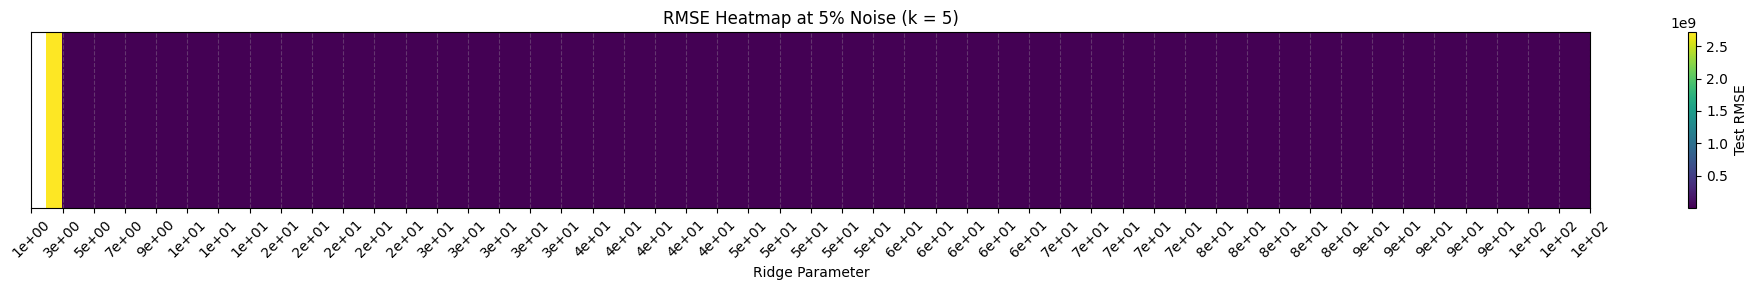

In [7]:
# ---------------------- Heatmap Phase 2 ----------------------
k_list = sorted(set(k for k, _, _ in results2))  # Only one value
ridge_list = sorted(set(r for _, r, _ in results2))

rmse_matrix = np.zeros((1, len(ridge_list)))
for _, ridge, rmse in results2:
    j = ridge_list.index(ridge)
    rmse_matrix[0, j] = rmse

log_ridge_list = ridge_list

# --- Plot heatmap ---
plt.figure(figsize=(20, 3))
im = plt.imshow(
    rmse_matrix,
    aspect='auto',
    origin='lower',
    extent=[log_ridge_list[0], log_ridge_list[-1], 0, 1],
    cmap='viridis'
)

plt.colorbar(im, label='Test RMSE')
plt.xlabel('Ridge Parameter')
plt.yticks([])
plt.title(f'RMSE Heatmap at 5% Noise (k = {k_list[0]})')
plt.xticks(
    log_ridge_list[::2],
    [f"{v:.0e}" for v in ridge_list][::2],
    rotation=45
)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("grid_search_rmse_heatmap_10percent_2(95_5_split)_obs_4.png", dpi=600)
plt.show()
